# Importación de librerías

In [ ]:
# Importar librerías
import pandas as pd
import numpy as np
import math
import statistics as sta
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.manifold import Isomap
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from random import seed
from random import randint
import random

from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve                         # thresholds = all unique prediction probabilities in descending order

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import LocallyLinearEmbedding

import time
import warnings
warnings.filterwarnings('ignore')

Constantes

In [ ]:
nn = 60
mm = 5

# Definición de funciones

In [ ]:
def normalize(dataset):
    dataNorm=(dataset-dataset.mean())/(dataset.std())
    dataNorm["Emotions"]=dataset["Emotions"]
    return dataNorm

def suffle_df(X, i, j, k):
  #a=X.iloc[0:8].copy()
  a=X
  #print(a)
  b,c=a.iloc[0:i+k].copy(),a.iloc[j:j+k].copy()
  b.reset_index(inplace=True, drop=True)
  c.reset_index(inplace=True, drop=True)
  b.index=b.index + j  # modify the values of the index such that 'b' variable can be replaced.

  a.iloc[0:i+k], a.iloc[j:j+k]=c,b
  return(a)

def make_dataframes_classes_same_length(x, Eps, prop, rng, noise_type):
  e0=x[(x['Emotions']==0)]
  e1=x[(x['Emotions']==1)]
  l_e0=len(e0)
  l_e1=len(e1)

  if l_e0>l_e1:
      e1=agument_Data(e1, Eps, prop, rng, noise_type)
  else:
      e0=agument_Data(e0, Eps, Eps, rng, noise_type)
  df_to_be_agumented = pd.concat([e0,e1])                   # concat the augmente observation at the end of the array.
  df_to_be_agumented.reset_index(inplace=True, drop=True)   # reset the index
  return df_to_be_agumented


def agument_Data(x, Eps, proportion, rng, noise_type):
  N=int(proportion*len(x))
  df_to_be_agumented=x

  if noise_type == 'gaussian':
    rn=rng.normal(0, Eps, size=(1, x.shape[1]))
  elif noise_type == 'laplace':
    rn=rng.laplace(0, Eps, size=(1, x.shape[1]))
  elif noise_type == 'uniform':
    rn=rng.uniform(-Eps, Eps, size=(1, x.shape[1]))
  elif noise_type == 'poisson':
    rn=rng.poisson(Eps, size=(1, x.shape[1]))
  else:
    print('Noise type not supported')

  #print('rn=',rn)

  for i in range(N):                            # create new N data. Where N are the required proportion.
    rd_row=random.randint(0,len(x)-1)           # randomly select one row to include noise.
    #print('i',i,'rd_row',rd_row)
    b=x.values[rd_row,0:x.shape[1]]+rn          # add Gaussian Noise to the selected observation.
    b=pd.DataFrame(data=b)                      # return format to Panda Dataframe
    b.columns = x.columns                       # re-name the new dataframe with the original names of the columns
    b.values[0,b.shape[1]-1]=int(x.values[rd_row,b.shape[1]-1]) # convert to integer the last value (this is the value used to classify)
    df_to_be_agumented = pd.concat([df_to_be_agumented,b])      # concat the augmente observation at the end of the array.
    df_to_be_agumented.reset_index(inplace=True, drop=True)     # reset the index
  return(df_to_be_agumented)

def train_test_sets(x, i, k, Eps, pr,n,m, nf, col, rng, noise_type):
  X_test=x.values[i:k,col]
  y_test=x.values[i:k,nf]
  tmp=x.loc[k:len(x)]
  tmp = make_dataframes_classes_same_length(tmp, Eps, pr, rng, noise_type)
  X_train=tmp.values[k:len(tmp),col]
  y_train=tmp.values[k:len(tmp),nf]

  return X_train, X_test, y_train, y_test


def train_model(nn, mm, file_name, Eps, noise_type):
  LR_max_iter=500

  prop=0.2

  CV=5
  k=1
  acc_max=0
  for j in range(0,10):
    data = pd.read_csv(file_name, header = None)
    data_name = []
    for i in range(len(data.axes[1])):
      if i== len(data.axes[1])-1:
        data_name = data_name + ['Emotions']
      else:
        data_name = data_name + [str(i)]
    data_n = data_name
    data.columns = data_name
    data=normalize(data)
    nf = data.shape[1]-1 # número de features (componentes)
    nc = nf
    col = list(range(nc))
    random.seed(j)  # 150
    rng=np.random.RandomState(j) # 155, 555

    acc_acu=0
    accuracy_acc=0
    N=int(len(data)-k)
    step=1
    i=0
    for n in range(0,N,step):
      i+=1
      wd=data
      ar=suffle_df(wd, 0, n, k)
      X_train, X_test, y_train, y_test = train_test_sets(ar, 0, k, Eps, prop,nn,mm, nf, col, rng, noise_type)
      model = SVC(kernel='rbf') # random.seed(50), pr=0.2, rand in augmented data=117 : 0.887
      #Fitting de Random Forest
      model.fit(X_train, y_train)
      acc = model.score(X_test, y_test)
      acc_acu += acc
      predictions = model.predict(X_test)
      cm = confusion_matrix(y_test, predictions)
      accuracy= metrics.accuracy_score(y_test, predictions)
      accuracy_acc += accuracy

    acc_ave=acc_acu/i
    if acc_ave > acc_max:
      acc_max=acc_ave

    return model, acc_max

# Analisís de marcas de agua

El documento siguiente está basado en el trabajo de un modelo SVC con inserción de ruido Gaussiano de 0.2, que sería el modelo original.

La idea es agregar una marca de agua estructurada se convierte a un formato binario y se integra en los datos directamente en la señal. Lo cual es muy similar a como se inserta ruido a una señal. A diferencia de otras maneras de insertar sonido, esta manera es similar a insertar un ruido, por ejemplo gaussiano; es porque la marca de agua se inserta directamente en la señal, en vez de ser insertado en un espacio latente.

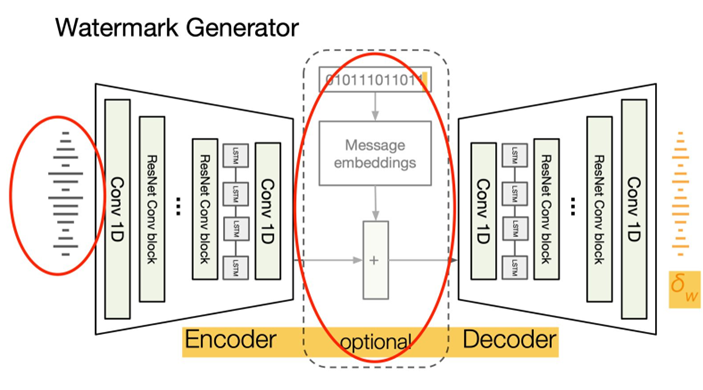![](attachment:image-2.png)

Independientemente del contenido dentro de la marca de agua, la idea es analizar el efecto que tiene la marca de agua en el modelo y como impacta las métricas del mismo modelo. En este caso seria, la métrica de exactitud.

Estaremos haciendo lo siguiente, generaremos una marca (que va de 0 a 30) el cual representarepresenta la desviación estándar de la señal, luego, aumentar Eps aumenta efectivamente la intensidad de la marca de agua.

Tambien probamos con diferentes tipos de señales:

•	Gaussiano

•	Laplaciano

•	Uniforme

•	Poisson

Con la intencion de comparar esta misma marca de agua integrada en diferentes señales y ver su comportamiento e impacto en el modelo

## Ruido gaussiano


El ruido gaussiano se caracteriza por una distribución de probabilidad en forma de campana, lo que significa que la mayoría de los valores de ruido se centran en la media y la probabilidad de desviaciones extremas disminuye simétricamente.

Este tipo de ruido surge comúnmente de fluctuaciones de circuitos electrónicos y ruido de sensores en sistemas de imágenes.

**Formula:**

$x' = x + \mathcal{N}(\mu, \sigma^2)$

In [ ]:
stress_historical_accuracy = []
anxiety_historical_accuracy = []
depression_historical_accuracy = []

noise_levels = np.arange(0, 30, 0.1)

for noise_level in noise_levels:
    print("################## Noise Level ", noise_level, '##################')
    stress_model, stress_accuracy = train_model(nn,mm, './stress_data.csv', noise_level, noise_type='gaussian')
    anxiety_model, anxiety_accuracy = train_model(nn,mm, './anxiety_data.csv', noise_level, noise_type='gaussian')
    depression_model, depression_accuracy = train_model(nn,mm, './depression_data.csv', noise_level, noise_type='gaussian')

    print("Stress Accuracy: ", stress_accuracy, " | Anxiety Accuracy: ", anxiety_accuracy, " | Depression Accuracy: ", depression_accuracy)

    stress_historical_accuracy.append(stress_accuracy)
    anxiety_historical_accuracy.append(anxiety_accuracy)
    depression_historical_accuracy.append(depression_accuracy)

################## Noise Level  0.0 ##################
Stress Accuracy:  0.6850393700787402  | Anxiety Accuracy:  0.6456692913385826  | Depression Accuracy:  0.7086614173228346
################## Noise Level  0.1 ##################
Stress Accuracy:  0.6929133858267716  | Anxiety Accuracy:  0.6456692913385826  | Depression Accuracy:  0.7086614173228346
################## Noise Level  0.2 ##################
Stress Accuracy:  0.6929133858267716  | Anxiety Accuracy:  0.6456692913385826  | Depression Accuracy:  0.7086614173228346
################## Noise Level  0.30000000000000004 ##################
Stress Accuracy:  0.6850393700787402  | Anxiety Accuracy:  0.6535433070866141  | Depression Accuracy:  0.7086614173228346
################## Noise Level  0.4 ##################
Stress Accuracy:  0.6771653543307087  | Anxiety Accuracy:  0.6535433070866141  | Depression Accuracy:  0.7165354330708661
################## Noise Level  0.5 ##################
Stress Accuracy:  0.6771653543307087  | Anxi

### Gráfica de estrés

Text(0, 0.5, 'Accuracy')

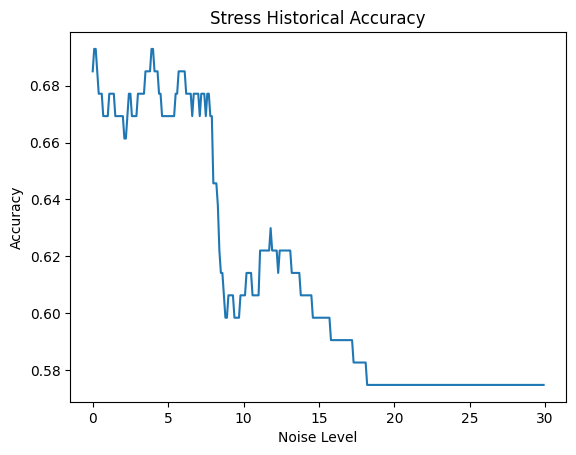

In [ ]:
plt.plot(noise_levels, stress_historical_accuracy)
plt.title("Stress Historical Accuracy")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")

Por lo general si hay una degradación de alrededor de 0.2 al insertar una marca de agua.

Existe una gran degradación cuando metemos un nivel de sonido de alrededor de 8, baja la exactitud bastante llegando a los niveles de 0.60.

Finalmente, después de llegar a un nivel de sonido de alrededor de 18, la exactitud llega a un punto de estancamiento de 0.58.



### Gráfica de ansiedad

Text(0, 0.5, 'Accuracy')

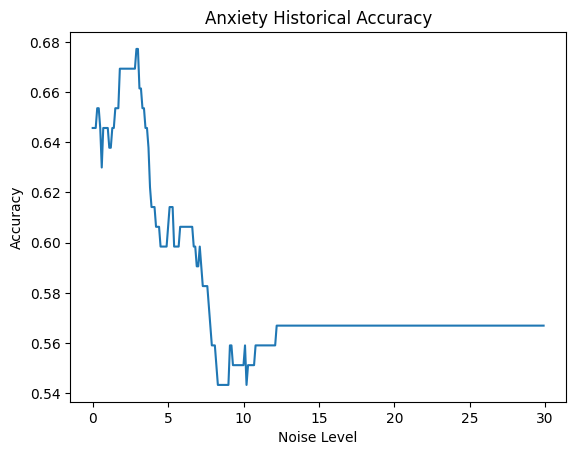

In [ ]:
plt.plot(noise_levels, anxiety_historical_accuracy)
plt.title("Anxiety Historical Accuracy")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")

Por lo general si hay una degradación de alrededor de 0.4 al insertar una marca de agua.

Existe una gran degradación cuando metemos un nivel de sonido de alrededor de 4, baja la exactitud bastante llegando a los niveles de 0.60.

Finalmente, después de llegar a un nivel de sonido de alrededor de 12, la exactitud llega a un punto de estancamiento de 0.57 aproximadamente.

### Gráfica de depresión

Text(0, 0.5, 'Accuracy')

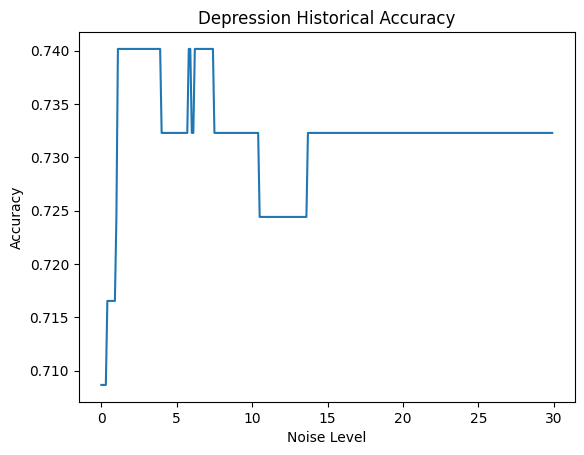

In [ ]:
plt.plot(noise_levels, depression_historical_accuracy)
plt.title("Depression Historical Accuracy")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")

La exactitud sube llegando a niveles de alrededor de 0.735, cuando aplicamos una marca de agua.

Al aplicar un nivel de sonido de 10 baja la exactitud a 0.725.

Finalmente, después de llegar a un nivel de sonido de alrededor de 14, la exactitud llega a un punto de estancamiento de 0.733 aproximadamente.

## Ruido laplaciano

El ruido laplaciano sigue una distribución doblemente exponencial, caracterizada por picos más nítidos en la media y colas más pesadas en comparación con el ruido gaussiano.

Esto lo hace más adecuado para modelar cambios rápidos o valores atípicos en los datos. En el procesamiento de imágenes, el operador laplaciano se utiliza a menudo para resaltar regiones de cambio rápido de intensidad, lo que ayuda a la detección de bordes.

**Formula:**

$x' = x + b \cdot \text{sign}(u) \cdot \ln(1 - 2|u|)$

In [ ]:
stress_historical_accuracy = []
anxiety_historical_accuracy = []
depression_historical_accuracy = []

noise_levels = np.arange(0, 30, 0.1)

for noise_level in noise_levels:
    print("################## Noise Level ", noise_level, '##################')
    stress_model, stress_accuracy = train_model(nn,mm, './stress_data.csv', noise_level, noise_type='laplace')
    anxiety_model, anxiety_accuracy = train_model(nn,mm, './anxiety_data.csv', noise_level, noise_type='laplace')
    depression_model, depression_accuracy = train_model(nn,mm, './depression_data.csv', noise_level, noise_type='laplace')

    print("Stress Accuracy: ", stress_accuracy, " | Anxiety Accuracy: ", anxiety_accuracy, " | Depression Accuracy: ", depression_accuracy)

    stress_historical_accuracy.append(stress_accuracy)
    anxiety_historical_accuracy.append(anxiety_accuracy)
    depression_historical_accuracy.append(depression_accuracy)

################## Noise Level  0.0 ##################
Stress Accuracy:  0.6850393700787402  | Anxiety Accuracy:  0.6456692913385826  | Depression Accuracy:  0.7086614173228346
################## Noise Level  0.1 ##################
Stress Accuracy:  0.6771653543307087  | Anxiety Accuracy:  0.6535433070866141  | Depression Accuracy:  0.7007874015748031
################## Noise Level  0.2 ##################
Stress Accuracy:  0.6771653543307087  | Anxiety Accuracy:  0.6456692913385826  | Depression Accuracy:  0.7086614173228346
################## Noise Level  0.30000000000000004 ##################
Stress Accuracy:  0.6692913385826772  | Anxiety Accuracy:  0.6377952755905512  | Depression Accuracy:  0.7086614173228346
################## Noise Level  0.4 ##################
Stress Accuracy:  0.6692913385826772  | Anxiety Accuracy:  0.6299212598425197  | Depression Accuracy:  0.7165354330708661
################## Noise Level  0.5 ##################
Stress Accuracy:  0.6692913385826772  | Anxi

### Gráfica de estrés

Text(0, 0.5, 'Accuracy')

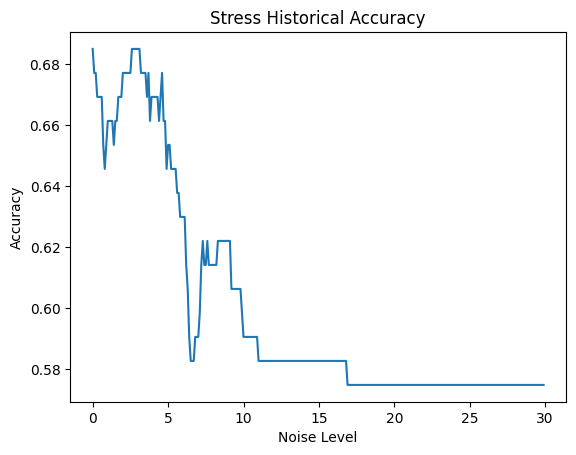

In [ ]:
plt.plot(noise_levels, stress_historical_accuracy)
plt.title("Stress Historical Accuracy")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")

Por lo general si hay una degradación de alrededor de 0.6 al insertar una marca de agua.

Existe una gran degradación cuando metemos un nivel de sonido de alrededor de 5, baja la exactitud bastante llegando a los niveles de 0.55.

Finalmente, después de llegar a un nivel de sonido de alrededor de 16, la exactitud llega a un punto de estancamiento de 0.58.

### Gráfica de ansiedad

Text(0, 0.5, 'Accuracy')

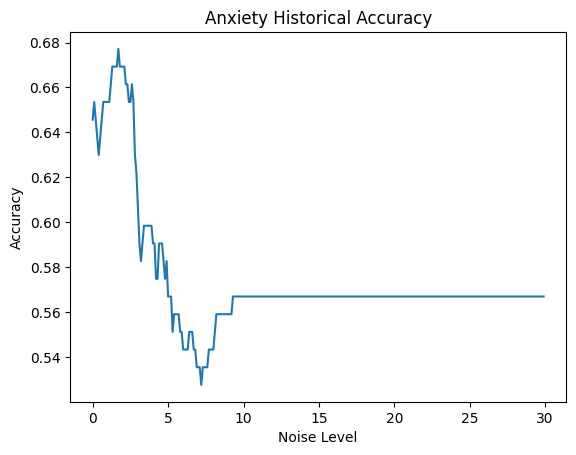

In [ ]:
plt.plot(noise_levels, anxiety_historical_accuracy)
plt.title("Anxiety Historical Accuracy")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")

Por lo general si hay una degradación de alrededor de 0.4 al insertar una marca de agua.

Existe una gran degradación cuando metemos un nivel de sonido de alrededor de 4, baja la exactitud bastante llegando a los niveles de 0.56.

Finalmente, después de llegar a un nivel de sonido de alrededor de 8, la exactitud llega a un punto de estancamiento de 0.57 aproximadamente.

### Gráfica de depresión

Text(0, 0.5, 'Accuracy')

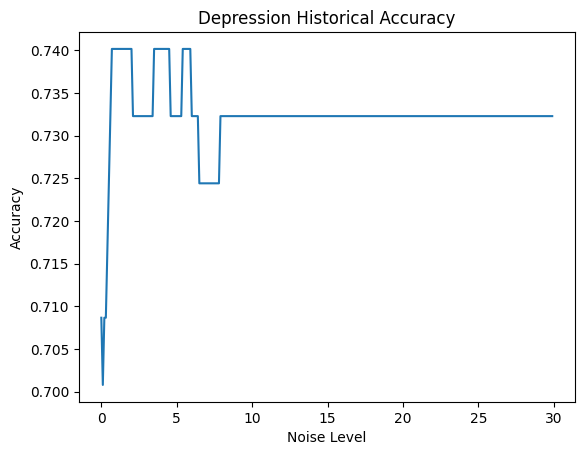

In [ ]:
plt.plot(noise_levels, depression_historical_accuracy)
plt.title("Depression Historical Accuracy")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")

La exactitud sube llegando a niveles de alrededor de 0.735, cuando aplicamos una marca de agua, baja un poco despues de llegar a un nivel de alrededor de 7.

Finalmente, después de llegar a un nivel de sonido de alrededor de 8, la exactitud llega a un punto de estancamiento de 0.733 aproximadamente.

## Ruido uniforme

El ruido uniforme se distribuye de manera uniforme en un rango específico, lo que significa que cada valor dentro del rango es igualmente probable. Este tipo de ruido se utiliza a menudo para simular el ruido de cuantificación en sistemas digitales o para modelar escenarios en los que todos los resultados dentro de un rango son igualmente probables.

**Formula:**

$x' = x + U(a, b)$

In [ ]:
stress_historical_accuracy = []
anxiety_historical_accuracy = []
depression_historical_accuracy = []

noise_levels = np.arange(0, 30, 0.1)

for noise_level in noise_levels:
    print("################## Noise Level ", noise_level, '##################')
    stress_model, stress_accuracy = train_model(nn,mm, './stress_data.csv', noise_level, noise_type='uniform')
    anxiety_model, anxiety_accuracy = train_model(nn,mm, './anxiety_data.csv', noise_level, noise_type='uniform')
    depression_model, depression_accuracy = train_model(nn,mm, './depression_data.csv', noise_level, noise_type='uniform')

    print("Stress Accuracy: ", stress_accuracy, " | Anxiety Accuracy: ", anxiety_accuracy, " | Depression Accuracy: ", depression_accuracy)

    stress_historical_accuracy.append(stress_accuracy)
    anxiety_historical_accuracy.append(anxiety_accuracy)
    depression_historical_accuracy.append(depression_accuracy)

################## Noise Level  0.0 ##################
Stress Accuracy:  0.6850393700787402  | Anxiety Accuracy:  0.6456692913385826  | Depression Accuracy:  0.7086614173228346
################## Noise Level  0.1 ##################
Stress Accuracy:  0.6771653543307087  | Anxiety Accuracy:  0.6456692913385826  | Depression Accuracy:  0.7007874015748031
################## Noise Level  0.2 ##################
Stress Accuracy:  0.6771653543307087  | Anxiety Accuracy:  0.6456692913385826  | Depression Accuracy:  0.7007874015748031
################## Noise Level  0.30000000000000004 ##################
Stress Accuracy:  0.6692913385826772  | Anxiety Accuracy:  0.6456692913385826  | Depression Accuracy:  0.7007874015748031
################## Noise Level  0.4 ##################
Stress Accuracy:  0.6692913385826772  | Anxiety Accuracy:  0.6535433070866141  | Depression Accuracy:  0.7086614173228346
################## Noise Level  0.5 ##################
Stress Accuracy:  0.6771653543307087  | Anxi

### Gráfica de estrés

Text(0, 0.5, 'Accuracy')

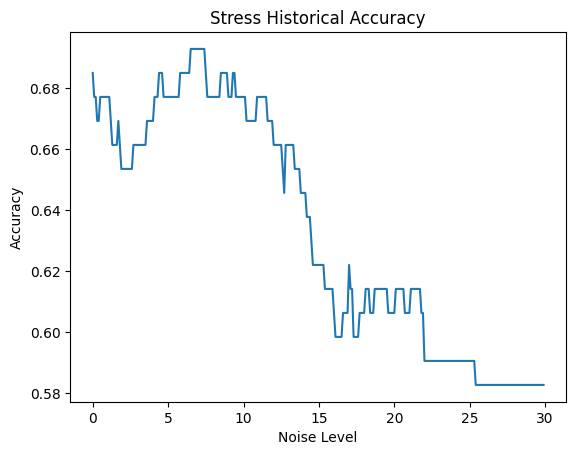

In [ ]:
plt.plot(noise_levels, stress_historical_accuracy)
plt.title("Stress Historical Accuracy")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")

Por lo general si hay una degradación de alrededor de 0.2 al insertar una marca de agua.

La caida no es tan grande como el resto de los modelos, pero decae cuando metemos un nivel de sonido de alrededor de 12, baja la exactitud bastante llegando a los niveles de 0.55.

Finalmente, después de llegar a un nivel de sonido de alrededor de 16, la exactitud dube alrededord de 0.61 y baja nuevamente cuando llegamos a un nivel superior de 21.

### Gráfica de ansiedad

Text(0, 0.5, 'Accuracy')

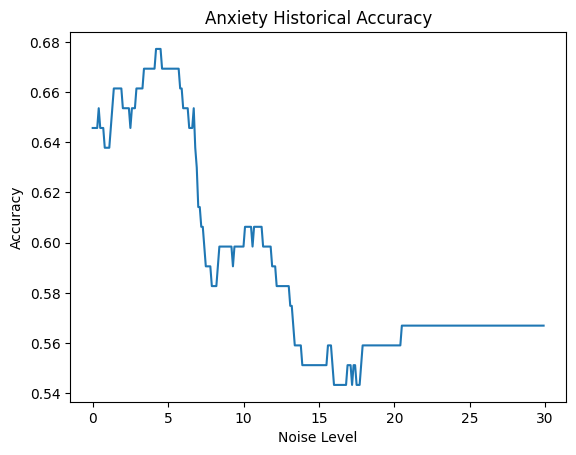

In [ ]:
plt.plot(noise_levels, anxiety_historical_accuracy)
plt.title("Anxiety Historical Accuracy")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")

Por lo general si hay una degradación de alrededor de 0.4 al insertar una marca de agua.

Existe una gran degradación cuando metemos un nivel de sonido de alrededor de 6, baja la exactitud bastante llegando a los niveles de 0.58.

Finalmente, después de llegar a un nivel de sonido de alrededor de 16, La exactitud sube un poco, despues del nivel 20 llega a un punto de stancamiento de estancamiento de 0.57 aproximadamente.

### Gráfica de depresión

Text(0, 0.5, 'Accuracy')

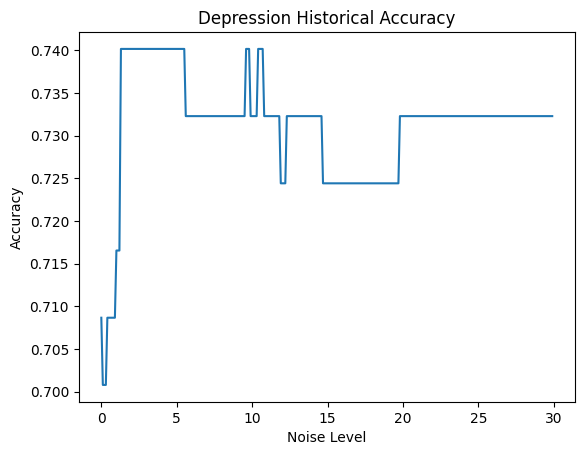

In [ ]:
plt.plot(noise_levels, depression_historical_accuracy)
plt.title("Depression Historical Accuracy")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")

La exactitud sube llegando a niveles de alrededor de 0.735, cuando aplicamos una marca de agua.

Despues de un nivel 5 de sonido, sube y baja la exactitud, llegando a un minimo de 0.725.

Finalmente, después de llegar a un nivel de sonido de alrededor de 20, la exactitud llega a un punto de estancamiento de 0.733 aproximadamente.

## Ruido de Poisson

El ruido de Poisson, también conocido como ruido de disparo, se observa normalmente en situaciones que implican el recuento de eventos discretos dentro de un intervalo fijo, como la detección de fotones en imágenes con poca luz. La varianza del ruido de Poisson es igual a su media, lo que lo hace dependiente de la señal.

**Formula:**

$x' = x + \text{Poisson}(\lambda)$

In [ ]:
stress_historical_accuracy = []
anxiety_historical_accuracy = []
depression_historical_accuracy = []

noise_levels = np.arange(0, 30, 0.1)

for noise_level in noise_levels:
    print("################## Noise Level ", noise_level, '##################')
    stress_model, stress_accuracy = train_model(nn,mm, './stress_data.csv', noise_level, noise_type='poisson')
    anxiety_model, anxiety_accuracy = train_model(nn,mm, './anxiety_data.csv', noise_level, noise_type='poisson')
    depression_model, depression_accuracy = train_model(nn,mm, './depression_data.csv', noise_level, noise_type='poisson')

    print("Stress Accuracy: ", stress_accuracy, " | Anxiety Accuracy: ", anxiety_accuracy, " | Depression Accuracy: ", depression_accuracy)

    stress_historical_accuracy.append(stress_accuracy)
    anxiety_historical_accuracy.append(anxiety_accuracy)
    depression_historical_accuracy.append(depression_accuracy)

################## Noise Level  0.0 ##################
Stress Accuracy:  0.6850393700787402  | Anxiety Accuracy:  0.6456692913385826  | Depression Accuracy:  0.7086614173228346
################## Noise Level  0.1 ##################
Stress Accuracy:  0.6771653543307087  | Anxiety Accuracy:  0.6377952755905512  | Depression Accuracy:  0.7165354330708661
################## Noise Level  0.2 ##################
Stress Accuracy:  0.6614173228346457  | Anxiety Accuracy:  0.6141732283464567  | Depression Accuracy:  0.7086614173228346
################## Noise Level  0.30000000000000004 ##################
Stress Accuracy:  0.6692913385826772  | Anxiety Accuracy:  0.6614173228346457  | Depression Accuracy:  0.7244094488188977
################## Noise Level  0.4 ##################
Stress Accuracy:  0.6614173228346457  | Anxiety Accuracy:  0.6614173228346457  | Depression Accuracy:  0.7244094488188977
################## Noise Level  0.5 ##################
Stress Accuracy:  0.6692913385826772  | Anxi

### Gráfica de estrés

Text(0, 0.5, 'Accuracy')

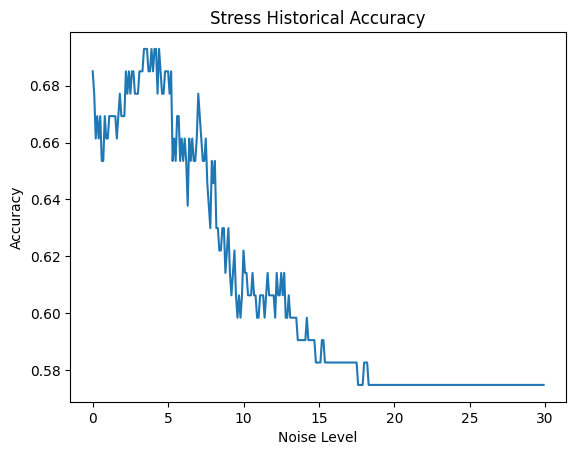

In [ ]:
plt.plot(noise_levels, stress_historical_accuracy)
plt.title("Stress Historical Accuracy")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")

A diferencia del resto de las graficas, esta señal es más sensible para la exactitud y el rendimiento general del modelo.

Por lo general si hay una ligera degradación de alrededor de 0.2 al insertar una marca de agua y sube despues del nivel de sonido de 3 aproximadamente.

La exactitud empeiza a degradarse cuando metemos un nivel de sonido de alrededor de 6, baja la exactitud no bajando mas del 0.60.

Finalmente, se degrada un poco mas despues del nimel de sonido de alrededor de 14 y llega a un punto de estancamiento de 0.58

### Gráfica de ansiedad

Text(0, 0.5, 'Accuracy')

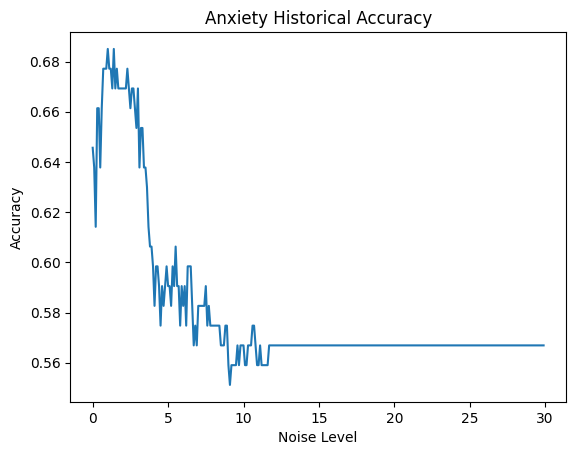

In [ ]:
plt.plot(noise_levels, anxiety_historical_accuracy)
plt.title("Anxiety Historical Accuracy")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")

A diferencia del resto de las graficas, esta señal es más sensible para la exactitud y el rendimiento general del modelo.

Por lo general si hay una ligera degradación de alrededor de 0.6 al insertar una marca de agua y sube despues del nivel de sonido de 3 aproximadamente.

La exactitud tiena una gran degradacion cuando metemos un nivel de sonido de alrededor de 4, llegando a nivels de alrededor de 0.58.

Finalmente, se degrada un poco mas despues del nimel de sonido de alrededor de 8 y llega a un punto de estancamiento de 0.57.

### Gráfica de depresión

Text(0, 0.5, 'Accuracy')

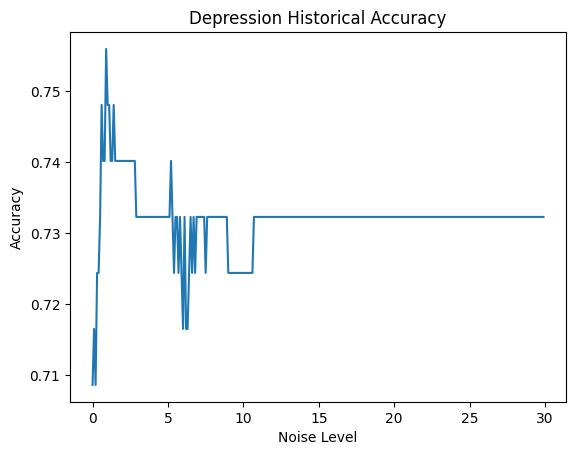

In [ ]:
plt.plot(noise_levels, depression_historical_accuracy)
plt.title("Depression Historical Accuracy")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")

Curiosamente, no parace ser tan sensible como el las otras dos etiquietas pero si existen más picos que en los otros gráficos de ruidos anterires.

La exactitud sube llegando a niveles de alrededor de 0.74, cuando aplicamos una marca de agua.

Al aplicar un nivel de sonido de 4, la exactitud baja y se mantiene entren iveles de 0.73 y 0.72.

Finalmente, después de llegar a un nivel de sonido de alrededor de 11, la exactitud llega a un punto de estancamiento de 0.735 aproximadamente.